![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Libraries --

To start, let's load those libraries that we need

In [ ]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

## 2. Model network architecture

In [ ]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(32, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))


To review a model, we just have to call the **.Summary()** method of the model

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_11 (Dense)            (None, 32)                262176    
                                                                 
 dense_12 (Dense)            (None, 10)                330       
                                                                 
Total params: 263,402
Trainable params: 263,402
Non-trainable params: 0
________________________________________________

## 3. Optimizer, error function


In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 4. We prepare the data --

We load the CIFAR10 data from the datasets directly from the Keras libraries. These are already ready in train and test

**Important detail:**
> The neural network requires that the inputs be real numbers, and we will do it by forcing the division of the values ​​within the 28x28 matrices (which have values​​ from 0 to 255) by 255.0 (a real)

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train_img, y_train), (x_test_img, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train_img / 255.0, x_test_img / 255.0

In [ ]:
y_train_label = y_train

y_test = ks.utils.to_categorical(y_test)
y_train = ks.utils.to_categorical(y_train)

y_test
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test.min()

0.0

We obtain an array with all the labels of CIFAR10

In [ ]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Let's paint a sample of the images from the CIFAR10 dataset, to see if it looks anything like what we expect.
First, we see what types of data I have, then we map those arrays in a grayscale using the **. Get_cmap ()** method of PlotLy with the first nine numbers of the dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


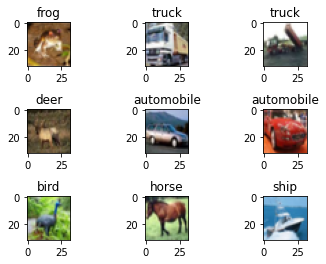

In [ ]:
# Lets paint a sample of the images of CIFAR10

print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train_scaled[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

We are we going to want to validate while we train (very practical)

In [ ]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]


this line is added because of the data augmentation and the vgg step later

In [ ]:
x_val_img = x_train_img[-10000:]
x_train_img_vgg=preprocess_input(x_train_img)
x_val_img_vgg = x_train_img_vgg[-10000:]

x_train_img_vgg = x_train_img_vgg[:-10000]
x_train_img = x_train_img[:-10000]



In [ ]:
x_train_scaled.shape

(40000, 32, 32, 3)

In [ ]:
y_val[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

When we add convolutions, we need to "pre-treat the data", because **the convolution expects an array of 4 fields** (more like "images"), in the case of MNIST. CIFAR10 already has the right shape, so we don't have to do anything, but as we always say: you better check its size.

Therefore, when exiting the Convolution, you have to do a Flatten, because FullDense layers expect arrays, not matrices !!

Then we print it to see that everything is correct

In [ ]:
# We validate the result
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)
Validation: X=(10000, 32, 32, 3), y=(10000, 10)


## 5. Training

We can start training the model! Be careful, we have to train against the data converted to the format expected by the Convolution.

We will start with 30 epocs, that is, 30 complete passes of the dataset (which in turn will be with mini-batches internally), setting a batch of 64

The .fit() method also allows us to define if we have several CPUs, GPUs, and if we want to validate data at each end of epoch.

In [ ]:
t = time.perf_counter()

In [ ]:
history = model.fit(x_train_scaled, y_train, epochs=20, 
                    use_multiprocessing=False, batch_size= 512, 
                    validation_data=(x_val_scaled, y_val))

Epoch 1/20
79/79 [==============================] - 3s 25ms/step - loss: 2.1004 - accuracy: 0.2378 - val_loss: 1.9097 - val_accuracy: 0.3141
Epoch 2/20
79/79 [==============================] - 2s 20ms/step - loss: 1.7832 - accuracy: 0.3710 - val_loss: 1.6989 - val_accuracy: 0.4008
Epoch 3/20
79/79 [==============================] - 2s 20ms/step - loss: 1.6298 - accuracy: 0.4195 - val_loss: 1.6773 - val_accuracy: 0.3916
Epoch 4/20
79/79 [==============================] - 2s 22ms/step - loss: 1.5650 - accuracy: 0.4427 - val_loss: 1.5355 - val_accuracy: 0.4525
Epoch 5/20
79/79 [==============================] - 2s 20ms/step - loss: 1.4991 - accuracy: 0.4684 - val_loss: 1.4964 - val_accuracy: 0.4666
Epoch 6/20
79/79 [==============================] - 2s 21ms/step - loss: 1.4583 - accuracy: 0.4794 - val_loss: 1.4909 - val_accuracy: 0.4732
Epoch 7/20
79/79 [==============================] - 2s 20ms/step - loss: 1.4293 - accuracy: 0.4899 - val_loss: 1.4860 - val_accuracy: 0.4706
Epoch 8/20
79

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:00:42.428567


## 6. We evaluate the results --

Let's obtain a graph of how the error and the accuracy evolve in each epoch in the training data and in the validation

In [ ]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 54.390


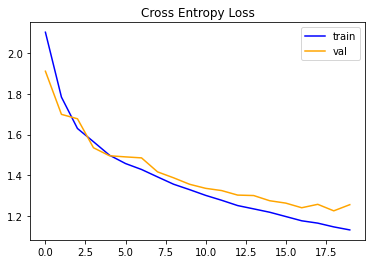

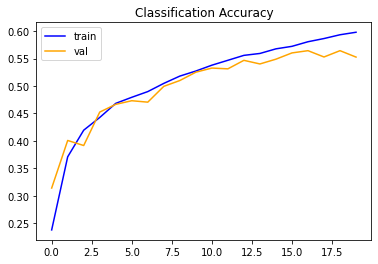

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

The cost we can see that it is stable and it is in the epoch 15 that it is set at a value. Also the accuracy dances around 0.10. It cannot be said that it is a very good model.

Let's see what kind of predictions I'm getting about the test set (let's paint the images and their classifications)

In [ ]:
predictions = model.predict(x_test_scaled)

One of the advantages of Python is that there are loads of functions and code made by third parties. Here I have shot some nice functions (which I have adapted a bit to my needs) to be able to paint the images, their label (ground truth) and the classifications that we have made.

In [ ]:
y_test[1].argmax()

8

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i].argmax(), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i].argmax()
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

We draw the first images, with the predictions and their real values ​​(a total of 20 images, so as not to abuse your laptops)

We color the correct predictions in blue and the failures in red. Although I have printed the labels first so that we have a reference to the graphic.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


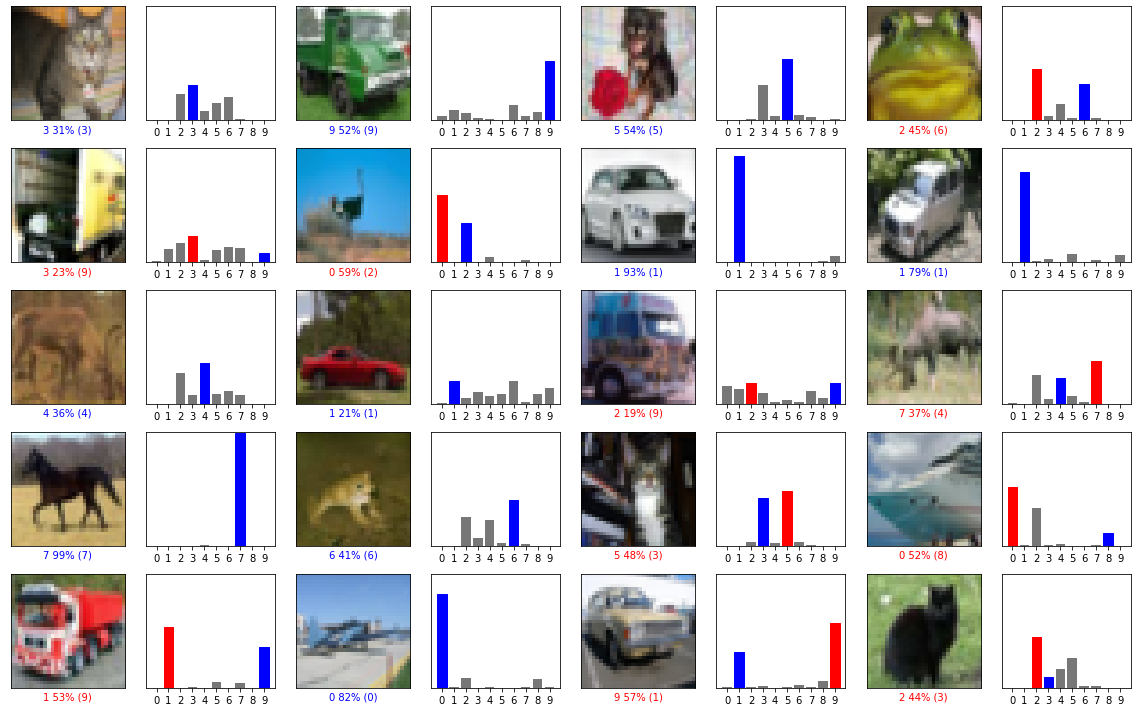

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. We save the model for future evaluations

Go changing the names of the file to save the various projects.
Here we save it in "local", but remember that the ideal is that you save it in Google Drive (you have to mount the unit, set the path and save the .h5 model there)

In [ ]:
model.save('cifar10_base_model.h5')

# Deep Learning Assignment
## By Eser Isler

10 different models, minimum 80 accuracy

# model 1
-adding more conv layers to the model 

-adding early stopping

In [ ]:
model1 = ks.Sequential()

model1.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model1.add(ks.layers.MaxPooling2D((2, 2)))

model1.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model1.add(ks.layers.MaxPooling2D((2, 2)))
model1.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same'))

model1.add(ks.layers.Flatten())
model1.add(ks.layers.Dense(64, activation='relu'))
model1.add(ks.layers.Dense(32, activation='relu'))
model1.add(ks.layers.Dense(10, activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_5 (Flatten)         (None, 8192)             

**Here we implement early stopping and implement the patience as 5 and restore_best_weights as true**

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
model1.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

In [ ]:
y_train.shape

(40000, 10)

In [ ]:
y_val.shape

(10000, 10)

## Training

In [ ]:
history = model1.fit(x_train_scaled, y_train, epochs=30, 
                     
                    batch_size= 64,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/30
625/625 [==============================] - 10s 15ms/step - loss: 1.6376 - accuracy: 0.3983 - val_loss: 1.3467 - val_accuracy: 0.5088
Epoch 2/30
625/625 [==============================] - 10s 15ms/step - loss: 1.2042 - accuracy: 0.5669 - val_loss: 1.1155 - val_accuracy: 0.6091
Epoch 3/30
625/625 [==============================] - 9s 15ms/step - loss: 1.0181 - accuracy: 0.6392 - val_loss: 1.0365 - val_accuracy: 0.6403
Epoch 4/30
625/625 [==============================] - 10s 15ms/step - loss: 0.8805 - accuracy: 0.6920 - val_loss: 0.9218 - val_accuracy: 0.6818
Epoch 5/30
625/625 [==============================] - 10s 16ms/step - loss: 0.7774 - accuracy: 0.7271 - val_loss: 0.8781 - val_accuracy: 0.6961
Epoch 6/30
625/625 [==============================] - 9s 15ms/step - loss: 0.6912 - accuracy: 0.7588 - val_loss: 0.8479 - val_accuracy: 0.7124
Epoch 7/30
625/625 [==============================] - 10s 15ms/step - loss: 0.6130 - accuracy: 0.7855 - val_loss: 0.8121 - val_accuracy: 0

The model stops early after 9 epochs. Let's evaluate.

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:01:55.664380


## Evaluation

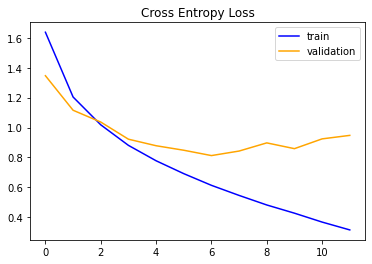

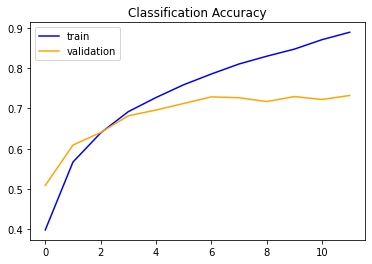

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

The graph shows the overfitting at the end.

In [ ]:
model1.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 1s - loss: 0.8200 - accuracy: 0.7241 - 1s/epoch - 4ms/step


[0.8200458288192749, 0.7240999937057495]

## The model 1 reached 70 % accuracy!

In [ ]:
predictions = model1.predict(x_test_scaled)

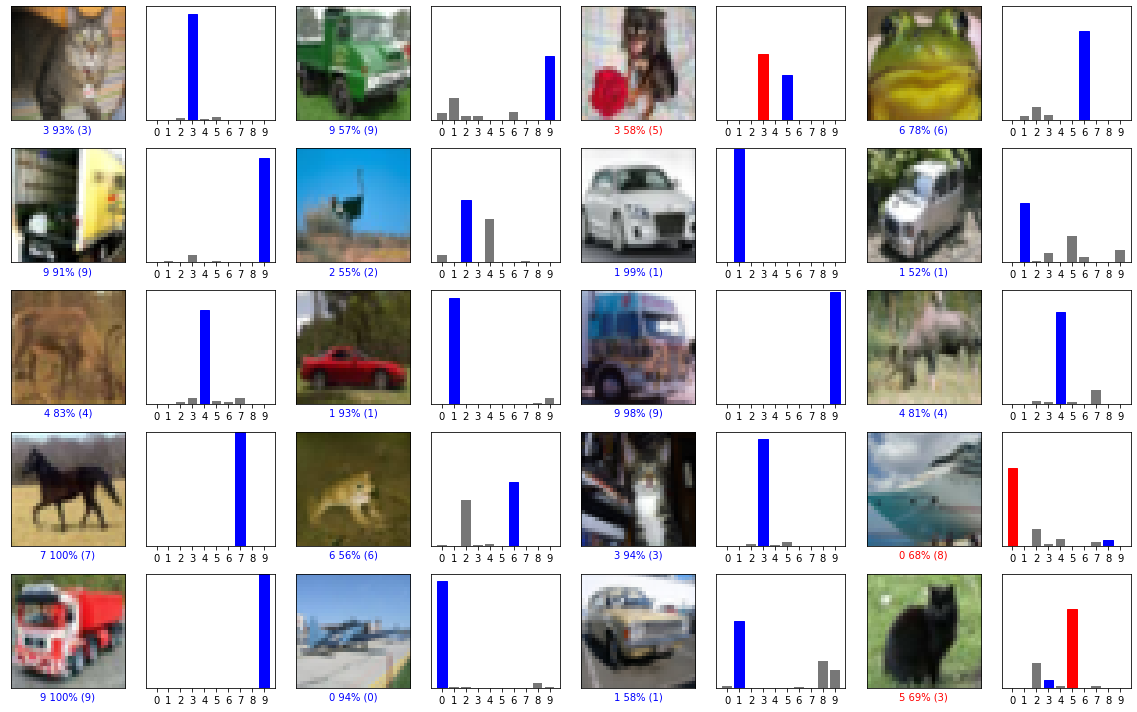

In [ ]:
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 2
-adding dropout to prevent overfitting

-adding data augmentation

other steps are going to be the same.

In [ ]:
model2 = ks.Sequential()

model2.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model2.add(ks.layers.MaxPooling2D((2, 2)))

model2.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model2.add(ks.layers.MaxPooling2D((2, 2)))
model2.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same'))

model2.add(ks.layers.Flatten())
model2.add(ks.layers.Dense(512, activation='relu'))
model2.add(ks.layers.Dropout(0.3))
model2.add(ks.layers.Dense(128, activation='relu'))
model2.add(ks.layers.Dropout(0.3))
model2.add(ks.layers.Dense(10, activation='softmax'))


In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_6 (Flatten)         (None, 8192)             

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

here we can add the data augmentation

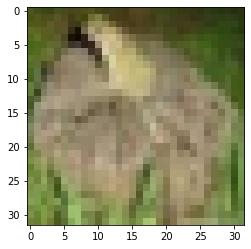

In [ ]:
sample = np.random.choice(range(0,4999))
image = x_train_scaled[sample]
plt.imshow(image, cmap=plt.cm.binary)


## image generation

here after trying many models I discovered:


-the loss as *sparse_categorical_crossentropy* didn't train well with generated images and stayed around 10 percent all the time.


-after I compared my model with a working model on the internet I realised the difference in y (mine was label and the working model was one hot encoded) and decided to try that out. After getting errors with the training, I realised to change the loss to 'categorical_crossentropy' and after that it started learning better.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    
    
    horizontal_flip=True,
    
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train_img,  
    y_train, 
    batch_size=16
)

In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val, 
    batch_size=16
)

In [ ]:
x_train_img.shape

(40000, 32, 32, 3)

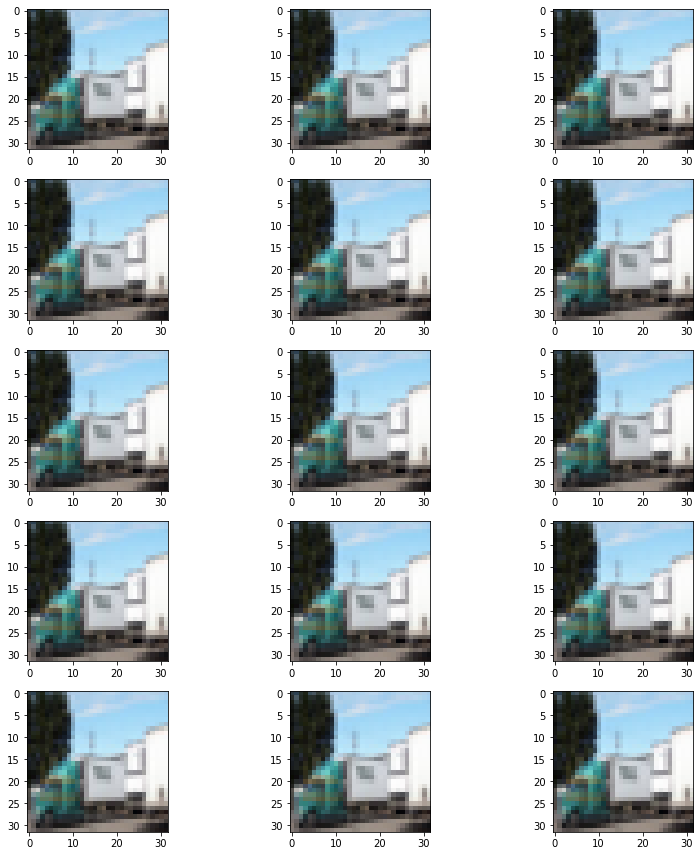

In [ ]:
sample = np.random.choice(range(0,9999))

example_generator = validation_datagen.flow(
    x_val_img[sample:sample+1],
    y_val[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(12, 12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

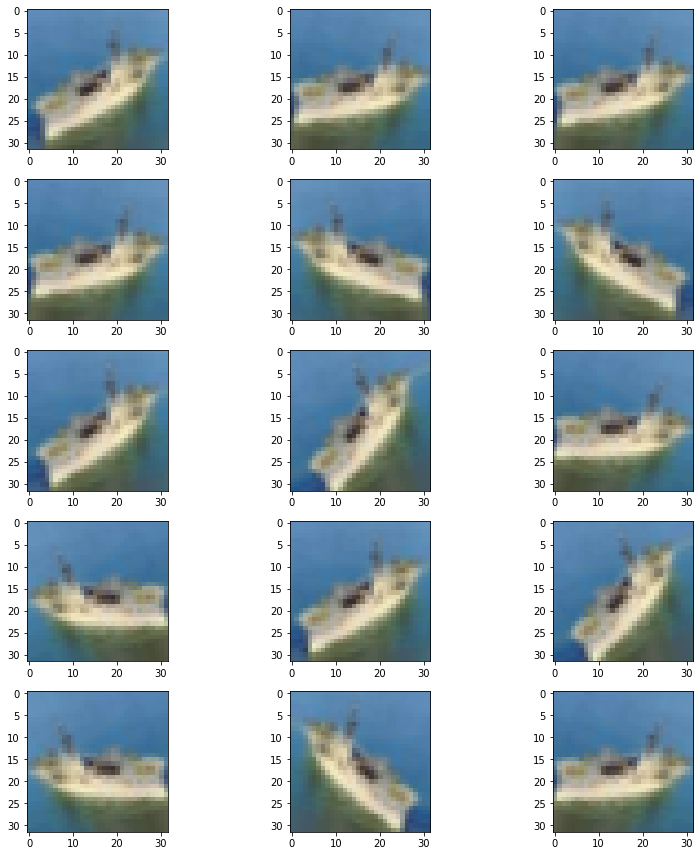

In [ ]:
sample = np.random.choice(range(0,39999))

example_generator = train_datagen.flow(
    x_train_img[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(12, 12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
epochs = 30
batch_size=16
history = model2.fit(train_generator, epochs=epochs, 
                    validation_data=validation_generator,
                    steps_per_epoch=2000 // batch_size,
                     validation_steps=800 // batch_size,
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/30
125/125 [==============================] - 3s 21ms/step - loss: 2.2405 - accuracy: 0.1395 - val_loss: 2.1038 - val_accuracy: 0.1937
Epoch 2/30
125/125 [==============================] - 2s 19ms/step - loss: 2.0801 - accuracy: 0.2170 - val_loss: 1.9300 - val_accuracy: 0.2713
Epoch 3/30
125/125 [==============================] - 2s 19ms/step - loss: 1.9309 - accuracy: 0.2730 - val_loss: 1.8146 - val_accuracy: 0.3225
Epoch 4/30
125/125 [==============================] - 2s 18ms/step - loss: 1.8043 - accuracy: 0.3380 - val_loss: 1.6844 - val_accuracy: 0.3738
Epoch 5/30
125/125 [==============================] - 2s 18ms/step - loss: 1.7325 - accuracy: 0.3705 - val_loss: 1.6129 - val_accuracy: 0.3837
Epoch 6/30
125/125 [==============================] - 2s 19ms/step - loss: 1.7249 - accuracy: 0.3685 - val_loss: 1.6667 - val_accuracy: 0.4100
Epoch 7/30
125/125 [==============================] - 2s 19ms/step - loss: 1.6658 - accuracy: 0.3840 - val_loss: 1.5857 - val_accuracy: 0.4250

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:01:15.180836


## Evaluation

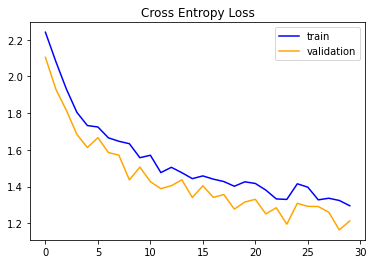

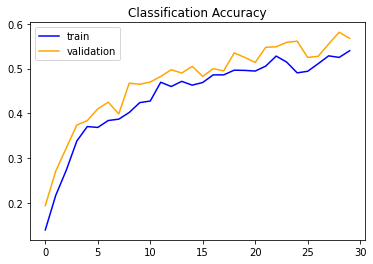

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
model2.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 2s - loss: 1.2322 - accuracy: 0.5560 - 2s/epoch - 6ms/step


[1.2322262525558472, 0.5559999942779541]

## The model 2 reached only 55 % accuracy

I will try the data augmentation again with a deeper model later.

In [ ]:
predictions = model2.predict(x_test_scaled)

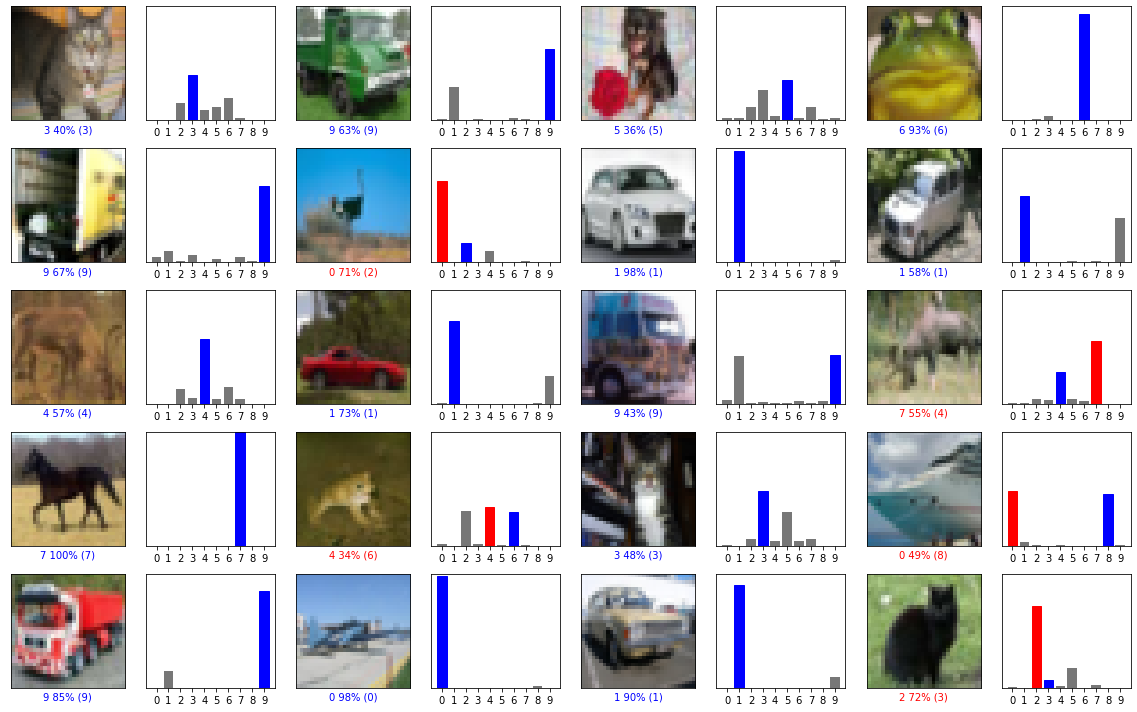

In [ ]:
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 3
-adding more conv layers to the model 

-adding batch normalization

-not using data augmentation for now

In [ ]:
model3 = ks.Sequential()

model3.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model3.add(ks.layers.BatchNormalization())

model3.add(ks.layers.MaxPooling2D((2, 2)))

model3.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model3.add(ks.layers.BatchNormalization())
model3.add(ks.layers.MaxPooling2D((2, 2)))
model3.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model3.add(ks.layers.BatchNormalization())

model3.add(ks.layers.Flatten())
model3.add(ks.layers.Dense(64, activation='relu'))
model3.add(ks.layers.BatchNormalization())
model3.add(ks.layers.Dense(32, activation='relu'))
model3.add(ks.layers.Dense(10, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
model3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
history = model3.fit(x_train_scaled, y_train, epochs=30, 
                    
                    batch_size= 64,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/30
625/625 [==============================] - 14s 20ms/step - loss: 1.2552 - accuracy: 0.5583 - val_loss: 1.1917 - val_accuracy: 0.5831
Epoch 2/30
625/625 [==============================] - 12s 19ms/step - loss: 0.8346 - accuracy: 0.7067 - val_loss: 1.2854 - val_accuracy: 0.5759
Epoch 3/30
625/625 [==============================] - 12s 19ms/step - loss: 0.6481 - accuracy: 0.7741 - val_loss: 1.1240 - val_accuracy: 0.6268
Epoch 4/30
625/625 [==============================] - 12s 19ms/step - loss: 0.4918 - accuracy: 0.8288 - val_loss: 1.0201 - val_accuracy: 0.6757
Epoch 5/30
625/625 [==============================] - 12s 19ms/step - loss: 0.3720 - accuracy: 0.8705 - val_loss: 1.2104 - val_accuracy: 0.6456
Epoch 6/30
625/625 [==============================] - 12s 19ms/step - loss: 0.2723 - accuracy: 0.9066 - val_loss: 1.4418 - val_accuracy: 0.6305
Epoch 7/30
625/625 [==============================] - 12s 19ms/step - loss: 0.2014 - accuracy: 0.9303 - val_loss: 1.3165 - val_accuracy:

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:01:48.965077


## Evaluating

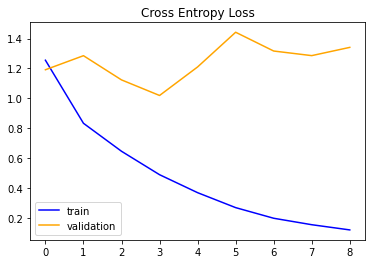

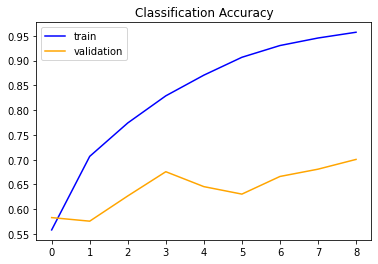

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

looking at the graph, there was overfitting

In [ ]:
model3.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 1s - loss: 1.0459 - accuracy: 0.6659 - 1s/epoch - 5ms/step


[1.0459421873092651, 0.6658999919891357]

## The model 3 reached 70 % accuracy



In [ ]:
predictions = model3.predict(x_test_scaled)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


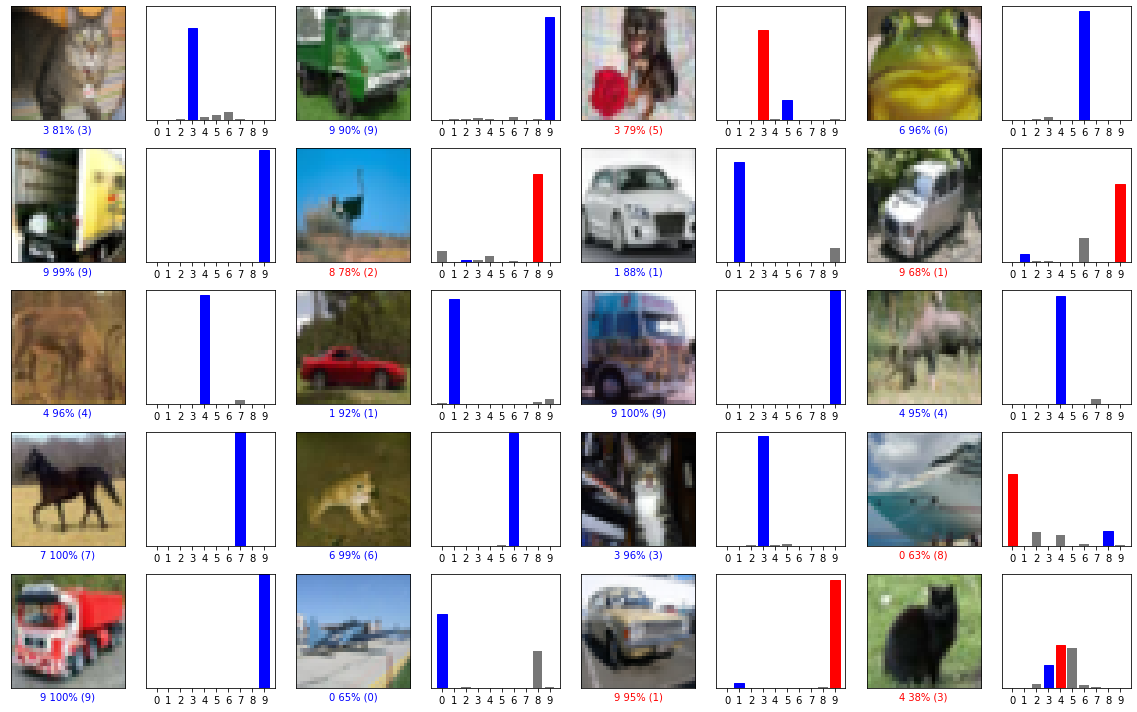

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 4

-adding dropout for overfitting


In [ ]:
model4 = ks.Sequential()


model4.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model4.add(ks.layers.BatchNormalization())

model4.add(ks.layers.MaxPooling2D((2, 2)))

model4.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model4.add(ks.layers.BatchNormalization())
model4.add(ks.layers.MaxPooling2D((2, 2)))
model4.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same'))
model4.add(ks.layers.BatchNormalization())
model4.add(ks.layers.Dropout(0.3))
model4.add(ks.layers.Flatten())
model4.add(ks.layers.Dense(64, activation='relu'))
model4.add(ks.layers.BatchNormalization())
model4.add(ks.layers.Dropout(0.3))
model4.add(ks.layers.Dense(32, activation='relu'))
model4.add(ks.layers.Dense(10, activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_15 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
model4.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
history = model4.fit(x_train_scaled, y_train, epochs=30, 
                     
                    batch_size= 64,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/30
625/625 [==============================] - 14s 20ms/step - loss: 1.4006 - accuracy: 0.5026 - val_loss: 1.1915 - val_accuracy: 0.5701
Epoch 2/30
625/625 [==============================] - 12s 20ms/step - loss: 1.0059 - accuracy: 0.6478 - val_loss: 0.9731 - val_accuracy: 0.6621
Epoch 3/30
625/625 [==============================] - 12s 19ms/step - loss: 0.8451 - accuracy: 0.7077 - val_loss: 0.8508 - val_accuracy: 0.7033
Epoch 4/30
625/625 [==============================] - 12s 20ms/step - loss: 0.7506 - accuracy: 0.7385 - val_loss: 0.9209 - val_accuracy: 0.6812
Epoch 5/30
625/625 [==============================] - 13s 20ms/step - loss: 0.6654 - accuracy: 0.7695 - val_loss: 0.8097 - val_accuracy: 0.7222
Epoch 6/30
625/625 [==============================] - 12s 20ms/step - loss: 0.5999 - accuracy: 0.7903 - val_loss: 0.8293 - val_accuracy: 0.7218
Epoch 7/30
625/625 [==============================] - 12s 19ms/step - loss: 0.5423 - accuracy: 0.8103 - val_loss: 0.8491 - val_accuracy:

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:03:42.130448


## Evaluating

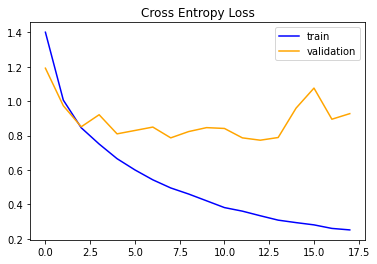

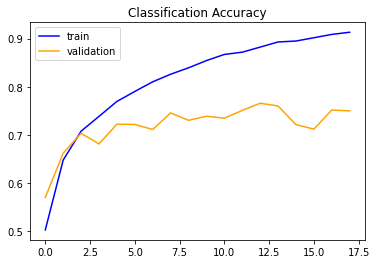

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
model4.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 1s - loss: 0.7901 - accuracy: 0.7603 - 1s/epoch - 5ms/step


[0.7901119589805603, 0.7602999806404114]

## The model 4 reached 74 % accuracy!

In [ ]:
predictions = model4.predict(x_test_scaled)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


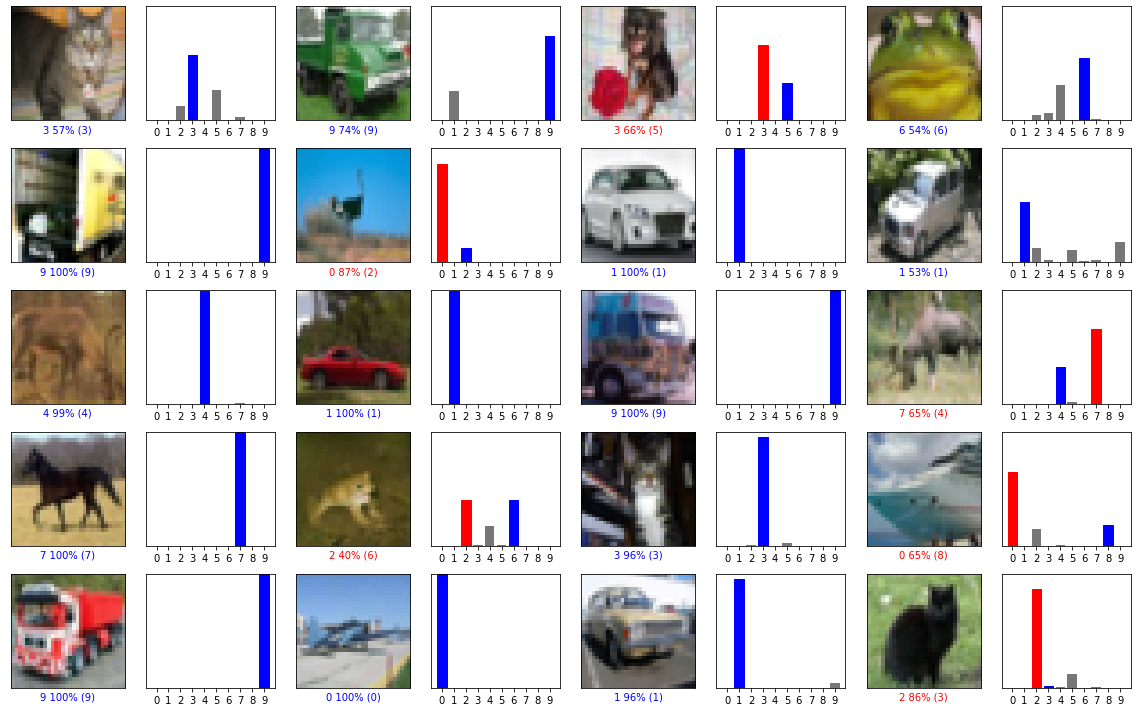

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 5
## -adding l2 regularisation for overfitting



In [ ]:
model5 = ks.Sequential()


model5.add(ks.layers.Conv2D(32, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model5.add(ks.layers.BatchNormalization())

model5.add(ks.layers.MaxPooling2D((2, 2)))

model5.add(ks.layers.Conv2D(64, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', 
                           padding='same'))
model5.add(ks.layers.BatchNormalization())
model5.add(ks.layers.MaxPooling2D((2, 2)))
model5.add(ks.layers.Conv2D(128, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model5.add(ks.layers.BatchNormalization())

model5.add(ks.layers.Dropout(0.3))
model5.add(ks.layers.Flatten())
model5.add(ks.layers.Dense(128,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model5.add(ks.layers.BatchNormalization())
model5.add(ks.layers.Dropout(0.3))
model5.add(ks.layers.Dense(32,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model5.add(ks.layers.Dense(10,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax'))

In [ ]:
model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_19 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
model5.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
history = model5.fit(x_train_scaled, y_train, epochs=30, 
                    
                    batch_size= 64,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/30
625/625 [==============================] - 15s 22ms/step - loss: 3.2218 - accuracy: 0.5114 - val_loss: 2.4242 - val_accuracy: 0.4427
Epoch 2/30
625/625 [==============================] - 13s 21ms/step - loss: 1.8860 - accuracy: 0.6251 - val_loss: 2.2030 - val_accuracy: 0.5048
Epoch 3/30
625/625 [==============================] - 13s 21ms/step - loss: 1.8105 - accuracy: 0.6469 - val_loss: 2.3420 - val_accuracy: 0.4781
Epoch 4/30
625/625 [==============================] - 14s 22ms/step - loss: 1.7671 - accuracy: 0.6609 - val_loss: 1.8996 - val_accuracy: 0.6109
Epoch 5/30
625/625 [==============================] - 14s 22ms/step - loss: 1.7658 - accuracy: 0.6672 - val_loss: 2.2588 - val_accuracy: 0.5258
Epoch 6/30
625/625 [==============================] - 13s 21ms/step - loss: 1.7423 - accuracy: 0.6753 - val_loss: 1.9092 - val_accuracy: 0.6110
Epoch 7/30
625/625 [==============================] - 13s 21ms/step - loss: 1.7334 - accuracy: 0.6815 - val_loss: 2.2405 - val_accuracy:

## Evaluating

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:02:56.926567


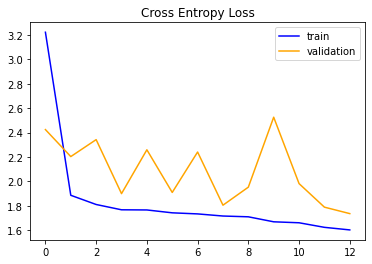

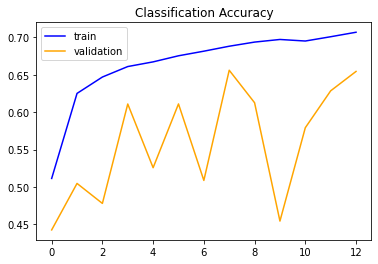

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
model5.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 2s - loss: 1.8217 - accuracy: 0.6496 - 2s/epoch - 5ms/step


[1.821678876876831, 0.6496000289916992]

## The model 5 reached 65 % accuracy.

-even though I added l2 regularisation, it didn't help with the overfitting at the end and stopped early.

In [ ]:
predictions = model5.predict(x_test_scaled)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


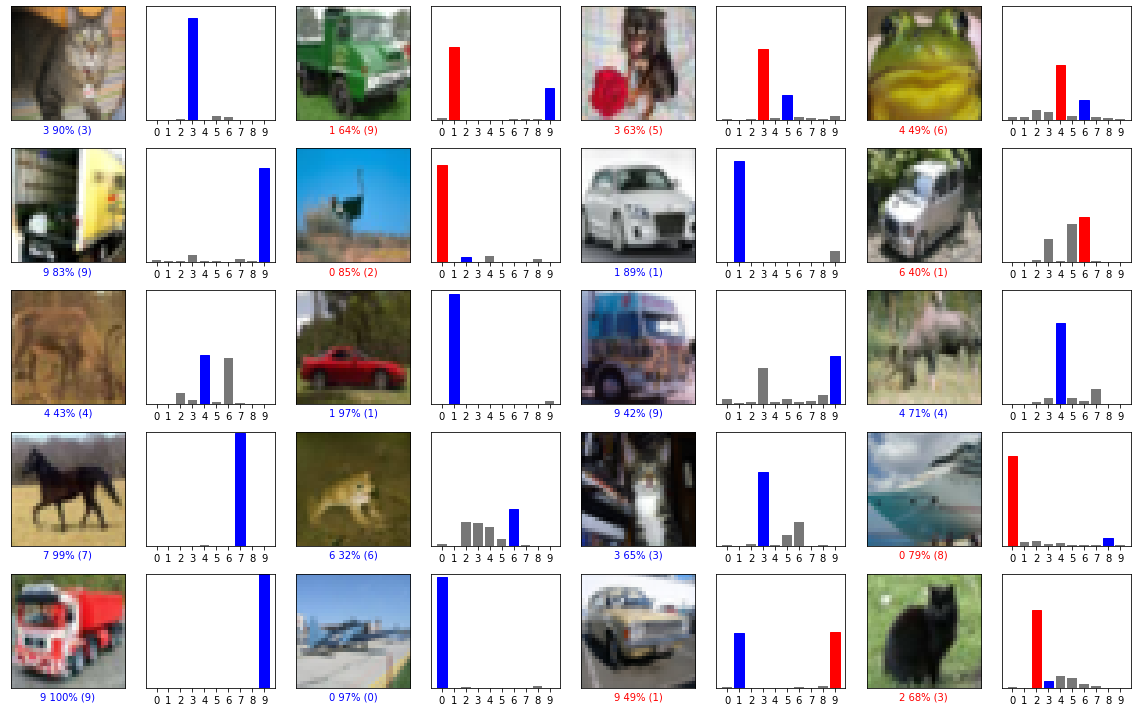

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1
    
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 6
## -adding one more convolutional layer



In [ ]:
model6 = ks.Sequential()


model6.add(ks.layers.Conv2D(32, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model6.add(ks.layers.BatchNormalization())

model6.add(ks.layers.MaxPooling2D((2, 2)))

model6.add(ks.layers.Conv2D(64, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', 
                           padding='same'))
model6.add(ks.layers.BatchNormalization())
model6.add(ks.layers.MaxPooling2D((2, 2)))
model6.add(ks.layers.Conv2D(128, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model6.add(ks.layers.BatchNormalization())
model6.add(ks.layers.MaxPooling2D((2, 2)))

model6.add(ks.layers.Conv2D(256, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model6.add(ks.layers.BatchNormalization())
model6.add(ks.layers.MaxPooling2D((2, 2)))


model6.add(ks.layers.Dropout(0.3))
model6.add(ks.layers.Flatten())
model6.add(ks.layers.Dense(128,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model6.add(ks.layers.BatchNormalization())
model6.add(ks.layers.Dropout(0.3))
model6.add(ks.layers.Dense(32,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model6.add(ks.layers.Dense(10,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax'))

In [ ]:
model6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_22 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_23 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                     

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
model6.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
history = model6.fit(x_train_scaled, y_train, epochs=30, 
                     
                    batch_size= 64,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/30
625/625 [==============================] - 18s 27ms/step - loss: 4.0447 - accuracy: 0.4841 - val_loss: 2.4553 - val_accuracy: 0.4341
Epoch 2/30
625/625 [==============================] - 16s 26ms/step - loss: 1.8747 - accuracy: 0.6209 - val_loss: 1.9614 - val_accuracy: 0.5512
Epoch 3/30
625/625 [==============================] - 16s 26ms/step - loss: 1.7401 - accuracy: 0.6554 - val_loss: 1.9505 - val_accuracy: 0.5670
Epoch 4/30
625/625 [==============================] - 16s 26ms/step - loss: 1.7041 - accuracy: 0.6681 - val_loss: 1.9061 - val_accuracy: 0.5935
Epoch 5/30
625/625 [==============================] - 16s 26ms/step - loss: 1.6656 - accuracy: 0.6819 - val_loss: 1.7814 - val_accuracy: 0.6318
Epoch 6/30
625/625 [==============================] - 16s 26ms/step - loss: 1.6477 - accuracy: 0.6885 - val_loss: 1.8101 - val_accuracy: 0.6317
Epoch 7/30
625/625 [==============================] - 16s 26ms/step - loss: 1.6089 - accuracy: 0.6974 - val_loss: 1.5772 - val_accuracy:

## Evaluating

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:03:17.060728


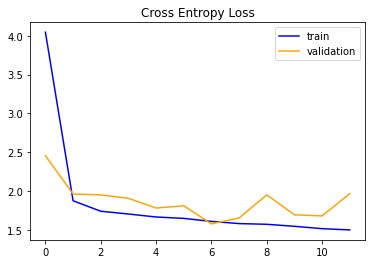

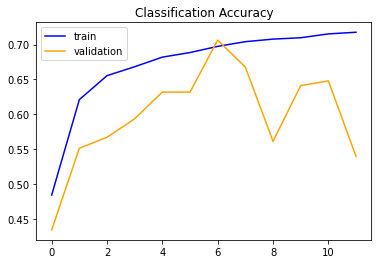

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
model6.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 2s - loss: 1.5816 - accuracy: 0.7017 - 2s/epoch - 6ms/step


[1.5816261768341064, 0.70169997215271]

## The model 6 reached 69 % accuracy.

-adding one more convolutional layer was still not enough to make the model deeper.

In [ ]:
predictions = model6.predict(x_test_scaled)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


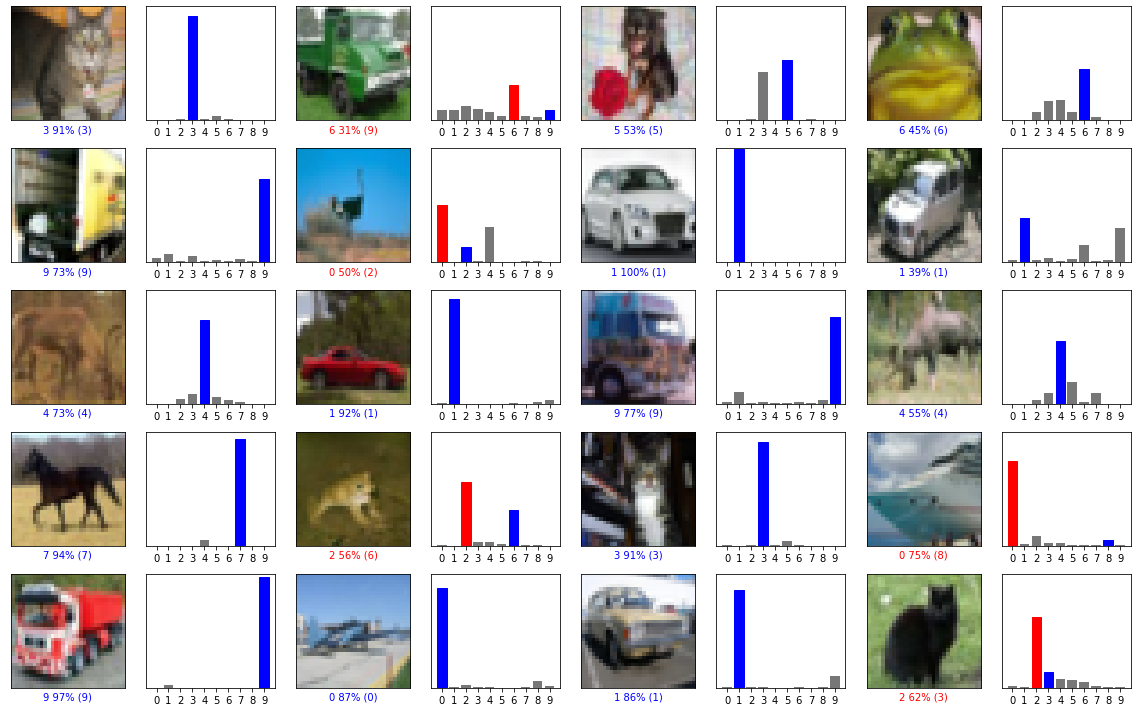

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1
    
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 7
## pretrained model

in this model I'm trying the vgg pretrained one imagenet and change some of the conv layers to be trainable and add dense layers at the end. 


In [ ]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3),classes=10)

58900480/58889256 [==============================] - 1s 0us/step


in the beginning of the notebook when I loaded the dataset, I applied a function to transform the img dataset into what is compatible with vgg by using the function 'preprocess_input'

In [ ]:
x_train_img_vgg.shape

(40000, 32, 32, 3)

In [ ]:
x_train_img[1,1,1,1]

153

In [ ]:
x_train_img_vgg[1,1,1,1]

36.221

we can see that the values in x_train_img_vgg are different than x_train_img 

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7fa63a1c9cd0>,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0x7fa630ab8b90>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x7fa62d024250>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x7fa6276f55d0>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x7fa62d63b890>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x7fa622b75f50>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x7fa63a324c90>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x7fa627590e50>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x7fa62d591d10>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x7fa622899810>,block3_conv3,True


## Freezing the vgg model
This code is to freeze the weights of the vgg model

In [ ]:
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

This code is to be able to make the conv layers after block4_conv1 trainable

In [ ]:
vgg_model.trainable = True

trainable = False
for layer in vgg_model.layers:
  if layer.name=='block4_conv1':
    trainable = True

  layer.trainable = trainable

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7fa63a1c9cd0>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7fa630ab8b90>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7fa62d024250>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7fa6276f55d0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7fa62d63b890>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7fa622b75f50>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fa63a324c90>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7fa627590e50>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7fa62d591d10>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7fa622899810>,block3_conv3,False


In [ ]:
input_shape = vgg_model.output_shape[1]
print(input_shape)

512


we need the input shape to add the rest of the model 

In [ ]:
model7 = ks.Sequential()



model7.add(vgg_model)
model7.add(ks.layers.Dense(256, activation='relu', input_shape=(input_shape,)))
model7.add(ks.layers.Dropout(0.3))
model7.add(ks.layers.Dense(128, activation='relu'))
model7.add(ks.layers.Dropout(0.3))
model7.add(ks.layers.Dense(10, activation='softmax')) 


In [ ]:
model7.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               14714688  
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 10)                1290      
                                                                 
Total params: 14,880,202
Trainable params: 13,144,714

here we can confirm that there are trainable parameters on vgg model

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)

In [ ]:
model7.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
x_val_img_vgg.shape

(10000, 32, 32, 3)

In [ ]:
y_val[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
history = model7.fit(x_train_img_vgg, y_train, epochs=30, 
                     
                    batch_size= 128,
                    validation_data=(x_val_img_vgg, y_val),
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/30
313/313 [==============================] - 43s 126ms/step - loss: 3.0084 - accuracy: 0.0969 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 2/30
313/313 [==============================] - 37s 119ms/step - loss: 2.3027 - accuracy: 0.1011 - val_loss: 2.3026 - val_accuracy: 0.0977
Epoch 3/30
313/313 [==============================] - 37s 118ms/step - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3027 - val_accuracy: 0.1003
Epoch 4/30
 75/313 [======>.......................] - ETA: 25s - loss: 2.3026 - accuracy: 0.0996

KeyboardInterrupt: ignored

## Evaluating

I stopped the training after there was no change on loss or accuracy.


I tried many things but couldn't make this pretrained model work on cifar10 dataset. One reason can be the resolution of the images, that cifar10 only has 32x32 and vgg is trained on bigger images.

## The model 7 reached only 10% accuracy

# model 8
## adding data augmentation again to this better model

I wanted to try the data augmentation from model2 now with a deeper model.

I also added a kernel initializer 

I decided to try out another optimizer


In [ ]:
model8 = ks.Sequential()


model8.add(ks.layers.Conv2D(32, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model8.add(ks.layers.BatchNormalization())

model8.add(ks.layers.MaxPooling2D((2, 2)))

model8.add(ks.layers.Conv2D(64, (3, 3), strides=1, 
                            kernel_initializer='he_uniform',
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', 
                           padding='same'))
model8.add(ks.layers.BatchNormalization())
model8.add(ks.layers.MaxPooling2D((2, 2)))
model8.add(ks.layers.Conv2D(128, (3, 3), strides=1, 
                            kernel_initializer='he_uniform',
                             
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model8.add(ks.layers.BatchNormalization())
model8.add(ks.layers.MaxPooling2D((2, 2)))

model8.add(ks.layers.Conv2D(256, (3, 3), strides=1,
                            kernel_initializer='he_uniform',
                              
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model8.add(ks.layers.BatchNormalization())
model8.add(ks.layers.MaxPooling2D((2, 2)))


model8.add(ks.layers.Dropout(0.3))
model8.add(ks.layers.Flatten())
model8.add(ks.layers.Dense(128,kernel_initializer='he_uniform',
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model8.add(ks.layers.BatchNormalization())
model8.add(ks.layers.Dropout(0.3))
model8.add(ks.layers.Dense(32,kernel_initializer='he_uniform',
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model8.add(ks.layers.Dense(10,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax'))

In [ ]:
model8.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_27 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_28 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                     

Here I define another optimizer where I can change the learning rate.

In [ ]:
opt = ks.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
model8.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## image generation

this step is the same from model 2

In [ ]:
train_datagen = ImageDataGenerator(
    
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
    )

train_generator = train_datagen.flow(
    x_train_scaled,  
    y_train, 
    batch_size=64
)

In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val, 
    batch_size=16
    )

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


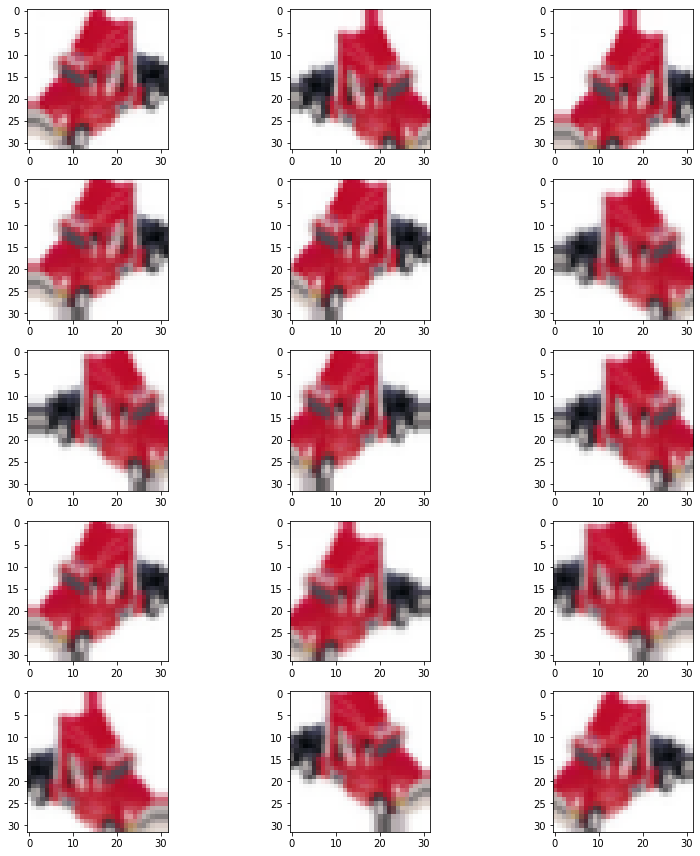

In [ ]:
sample = np.random.choice(range(0,39999))

example_generator = train_datagen.flow(
    x_train_scaled[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(12, 12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        print(y)
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Training

In [ ]:
x_val_scaled.shape

(10000, 32, 32, 3)

In [ ]:
y_val.shape

(10000, 10)

In [ ]:
epochs = 100
batch_size=16
steps = int(x_train_scaled.shape[0] / 64)
history = model8.fit(x= train_generator, epochs=epochs, 
                      steps_per_epoch=steps,
                    batch_size= 64,
                    validation_data=validation_generator,
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/100
625/625 [==============================] - 36s 54ms/step - loss: 12.9328 - accuracy: 0.3048 - val_loss: 11.2740 - val_accuracy: 0.4192
Epoch 2/100
625/625 [==============================] - 34s 54ms/step - loss: 10.1439 - accuracy: 0.4214 - val_loss: 8.9976 - val_accuracy: 0.4679
Epoch 3/100
625/625 [==============================] - 34s 55ms/step - loss: 8.1449 - accuracy: 0.4698 - val_loss: 7.3188 - val_accuracy: 0.4911
Epoch 4/100
625/625 [==============================] - 33s 53ms/step - loss: 6.6031 - accuracy: 0.5064 - val_loss: 5.8891 - val_accuracy: 0.5513
Epoch 5/100
625/625 [==============================] - 33s 53ms/step - loss: 5.3974 - accuracy: 0.5395 - val_loss: 5.0152 - val_accuracy: 0.5282
Epoch 6/100
625/625 [==============================] - 33s 53ms/step - loss: 4.4592 - accuracy: 0.5681 - val_loss: 3.9641 - val_accuracy: 0.6220
Epoch 7/100
625/625 [==============================] - 33s 53ms/step - loss: 3.7338 - accuracy: 0.5881 - val_loss: 3.3682 - val

## Evaluating

this model trained for 34 epochs, a long time.

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:24:42.771338


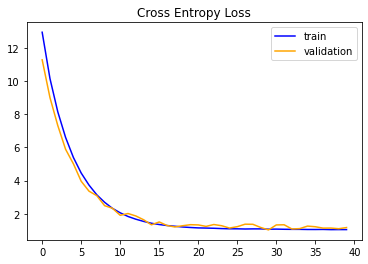

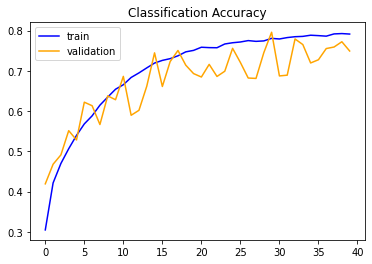

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
model8.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 2s - loss: 1.0638 - accuracy: 0.7828 - 2s/epoch - 7ms/step


[1.0638455152511597, 0.782800018787384]

## The model 8 reached  74% accuracy!

This was so much better than model 2. 

In [ ]:
predictions = model8.predict(x_test_scaled)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


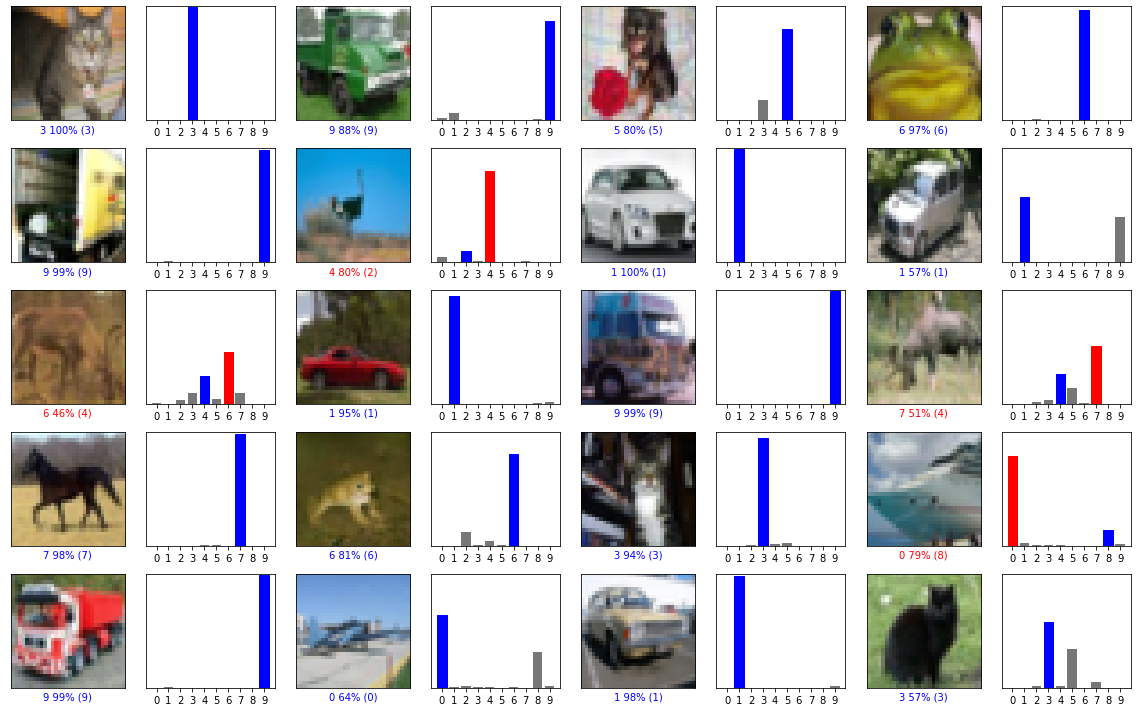

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1
    
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 9
## -adding several conv layers without maxpooling

-this model is without data augmentation.



In [ ]:
model9 = ks.Sequential()


model9.add(ks.layers.Conv2D(32, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model9.add(ks.layers.BatchNormalization())
model9.add(ks.layers.Conv2D(32, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model9.add(ks.layers.MaxPooling2D((2, 2)))

model9.add(ks.layers.Conv2D(64, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', 
                           padding='same'))
model9.add(ks.layers.BatchNormalization())
model9.add(ks.layers.Conv2D(64, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', 
                           padding='same'))
model9.add(ks.layers.MaxPooling2D((2, 2)))
model9.add(ks.layers.Conv2D(128, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model9.add(ks.layers.BatchNormalization())
model9.add(ks.layers.Conv2D(128, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model9.add(ks.layers.MaxPooling2D((2, 2)))

model9.add(ks.layers.Conv2D(256, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model9.add(ks.layers.BatchNormalization())
model9.add(ks.layers.Conv2D(256, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model9.add(ks.layers.MaxPooling2D((2, 2)))


model9.add(ks.layers.Dropout(0.3))
model9.add(ks.layers.Flatten())
model9.add(ks.layers.Dense(128,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model9.add(ks.layers.BatchNormalization())
model9.add(ks.layers.Dropout(0.3))
model9.add(ks.layers.Dense(32,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model9.add(ks.layers.Dense(10,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax'))

In [ ]:
model9.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_32 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_33 (Bat  (None, 16, 16, 64)     

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
model9.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
history = model9.fit(x_train_scaled, y_train, epochs=30, 
                     
                    batch_size= 64,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_accuracy, callback_loss])

Epoch 1/30
625/625 [==============================] - 31s 46ms/step - loss: 4.8946 - accuracy: 0.4604 - val_loss: 2.8102 - val_accuracy: 0.3271
Epoch 2/30
625/625 [==============================] - 28s 45ms/step - loss: 1.8626 - accuracy: 0.5892 - val_loss: 2.2745 - val_accuracy: 0.4352
Epoch 3/30
625/625 [==============================] - 28s 45ms/step - loss: 1.6720 - accuracy: 0.6241 - val_loss: 2.0711 - val_accuracy: 0.4782
Epoch 4/30
625/625 [==============================] - 28s 45ms/step - loss: 1.5915 - accuracy: 0.6540 - val_loss: 1.7749 - val_accuracy: 0.5986
Epoch 5/30
625/625 [==============================] - 28s 45ms/step - loss: 1.5368 - accuracy: 0.6715 - val_loss: 1.9105 - val_accuracy: 0.5356
Epoch 6/30
625/625 [==============================] - 28s 45ms/step - loss: 1.5002 - accuracy: 0.6878 - val_loss: 1.7775 - val_accuracy: 0.5698
Epoch 7/30
625/625 [==============================] - 28s 45ms/step - loss: 1.4706 - accuracy: 0.7007 - val_loss: 1.6970 - val_accuracy:

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:05:43.311424


## Evaulating

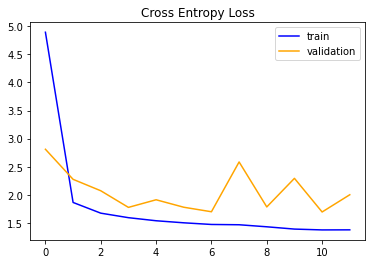

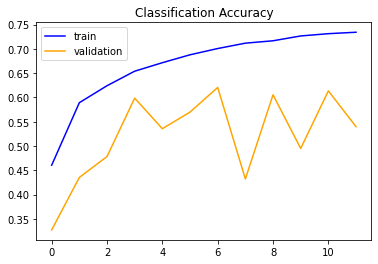

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
model9.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 3s - loss: 1.7040 - accuracy: 0.6226 - 3s/epoch - 11ms/step


[1.7039629220962524, 0.6226000189781189]

## The model 9 reached 64 % accuracy.

> because of overfitting the validation accuracy decreased sharply and the training stopped early



In [ ]:
predictions = model9.predict(x_test_scaled)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


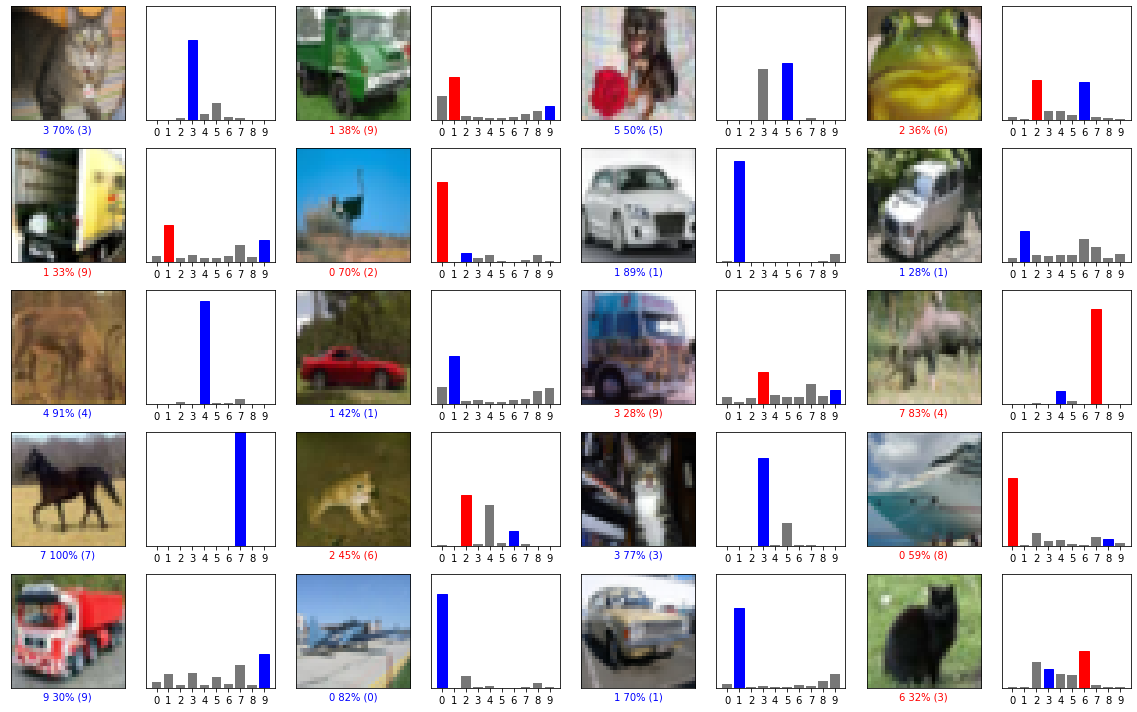

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1
    
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 10
## -using modelcheckpoint and turning back to the model that had the best val accuracy, then decreasing the learning rate and training again.

model architecture is the same as model9



In [ ]:
model10 = ks.Sequential()


model10.add(ks.layers.Conv2D(32, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model10.add(ks.layers.BatchNormalization())
model10.add(ks.layers.Conv2D(32, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model10.add(ks.layers.MaxPooling2D((2, 2)))

model10.add(ks.layers.Conv2D(64, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', 
                           padding='same'))
model10.add(ks.layers.BatchNormalization())
model10.add(ks.layers.Conv2D(64, (3, 3), strides=1, 
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', 
                           padding='same'))
model10.add(ks.layers.MaxPooling2D((2, 2)))
model10.add(ks.layers.Conv2D(128, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model10.add(ks.layers.BatchNormalization())
model10.add(ks.layers.Conv2D(128, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model10.add(ks.layers.MaxPooling2D((2, 2)))

model10.add(ks.layers.Conv2D(256, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model10.add(ks.layers.BatchNormalization())
model10.add(ks.layers.Conv2D(256, (3, 3), strides=1,  
                            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            activation='relu', 
                           padding='same'))
model10.add(ks.layers.MaxPooling2D((2, 2)))


model10.add(ks.layers.Dropout(0.3))
model10.add(ks.layers.Flatten())
model10.add(ks.layers.Dense(128,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model10.add(ks.layers.BatchNormalization())
model10.add(ks.layers.Dropout(0.3))
model10.add(ks.layers.Dense(32,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model10.add(ks.layers.Dense(10,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax'))

In [ ]:
model10.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_37 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_53 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_38 (Bat  (None, 16, 16, 64)     

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
checkpoint_filepath = '/content/checkpoints'

here I add as a callback a ModelCheckpoint that enables to save the best model weights to train later.

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

here I choose an optimizer which I can change the learning rate. 

Initially I start with 0.001

In [ ]:
opt = ks.optimizers.SGD(lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model10.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
history = model10.fit(x_train_scaled, y_train, epochs=30, 
                     
                    batch_size= 64,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_accuracy, callback_loss,model_checkpoint_callback])

Epoch 1/30
625/625 [==============================] - 31s 47ms/step - loss: 11.3518 - accuracy: 0.3688 - val_loss: 10.1035 - val_accuracy: 0.3956
Epoch 2/30
625/625 [==============================] - 29s 46ms/step - loss: 8.8045 - accuracy: 0.5379 - val_loss: 8.0543 - val_accuracy: 0.5008
Epoch 3/30
625/625 [==============================] - 29s 46ms/step - loss: 6.9829 - accuracy: 0.6191 - val_loss: 6.2912 - val_accuracy: 0.6245
Epoch 4/30
625/625 [==============================] - 29s 46ms/step - loss: 5.5907 - accuracy: 0.6770 - val_loss: 5.2599 - val_accuracy: 0.5978
Epoch 5/30
625/625 [==============================] - 29s 46ms/step - loss: 4.5171 - accuracy: 0.7170 - val_loss: 4.1297 - val_accuracy: 0.7097
Epoch 6/30
625/625 [==============================] - 29s 46ms/step - loss: 3.6856 - accuracy: 0.7516 - val_loss: 3.5888 - val_accuracy: 0.6655
Epoch 7/30
625/625 [==============================] - 29s 46ms/step - loss: 3.0338 - accuracy: 0.7798 - val_loss: 2.9680 - val_accurac

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:08:15.010753


## Evaulating

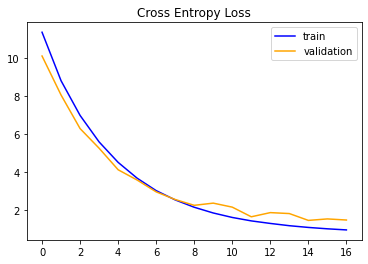

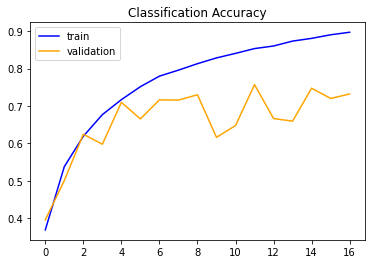

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
model10.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 3s - loss: 1.6717 - accuracy: 0.7498 - 3s/epoch - 10ms/step


[1.6716910600662231, 0.7498000264167786]

## The model 10 reached 76 % accuracy.

> Now I can take the saved model which has the weights of the best model and train again with a lower learning rate.



In [ ]:
predictions = model10.predict(x_test_scaled)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


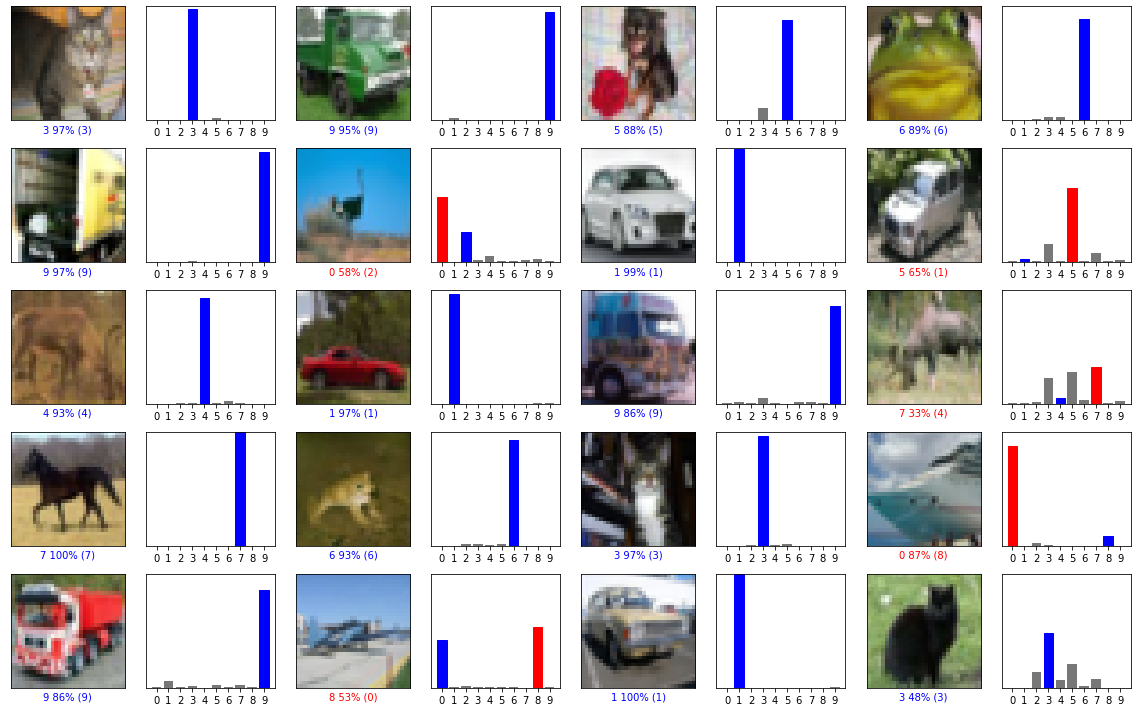

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1
    
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

# model 10 with different learning rate from last checkpoint
## now with loading weights from the checkpoint, model10 will have the best version of the last training that had 74% accuracy



In [ ]:
model10.load_weights(checkpoint_filepath)

Here I lower the learning rate and make it from 0.001 to 0.0001 

In [ ]:
opt = ks.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

In [ ]:
model10.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [ ]:
checkpoint_filepath = '/content/checkpoints'

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
t = time.perf_counter()

## Training

In [ ]:
history = model10.fit(x_train_scaled, y_train, epochs=30, 
                     
                    batch_size= 64,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_accuracy, callback_loss,model_checkpoint_callback])

Epoch 1/30
625/625 [==============================] - 32s 48ms/step - loss: 1.2016 - accuracy: 0.9219 - val_loss: 1.3964 - val_accuracy: 0.8376
Epoch 2/30
625/625 [==============================] - 29s 47ms/step - loss: 1.1231 - accuracy: 0.9456 - val_loss: 1.3747 - val_accuracy: 0.8401
Epoch 3/30
625/625 [==============================] - 29s 47ms/step - loss: 1.0750 - accuracy: 0.9574 - val_loss: 1.3621 - val_accuracy: 0.8389
Epoch 4/30
625/625 [==============================] - 29s 47ms/step - loss: 1.0348 - accuracy: 0.9663 - val_loss: 1.3553 - val_accuracy: 0.8378
Epoch 5/30
625/625 [==============================] - 29s 47ms/step - loss: 0.9986 - accuracy: 0.9734 - val_loss: 1.3325 - val_accuracy: 0.8405
Epoch 6/30
625/625 [==============================] - 29s 47ms/step - loss: 0.9666 - accuracy: 0.9792 - val_loss: 1.3285 - val_accuracy: 0.8374
Epoch 7/30
625/625 [==============================] - 29s 47ms/step - loss: 0.9381 - accuracy: 0.9839 - val_loss: 1.3192 - val_accuracy:

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Training time:', elapsed_time)

Training time: 0:06:54.196044


## Evaulating

the model seems better on validation accuracy now, let's see on the test dataset!

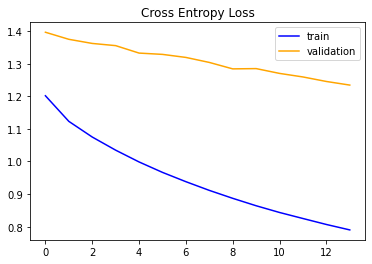

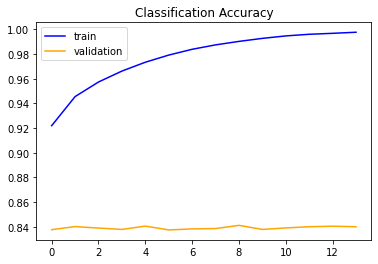

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [ ]:
model10.evaluate(x_test_scaled,  y_test, verbose=2)

313/313 - 3s - loss: 1.3001 - accuracy: 0.8366 - 3s/epoch - 10ms/step


[1.3001072406768799, 0.8366000056266785]

## The model 10 reached 84 % accuracy!

> by using the modelcheckpoint method and lowering the learning rate,on one of the deep models that I developed, with many overfitting methods implemented, I reach 84 % accuracy.



In [ ]:
predictions = model10.predict(x_test_scaled)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


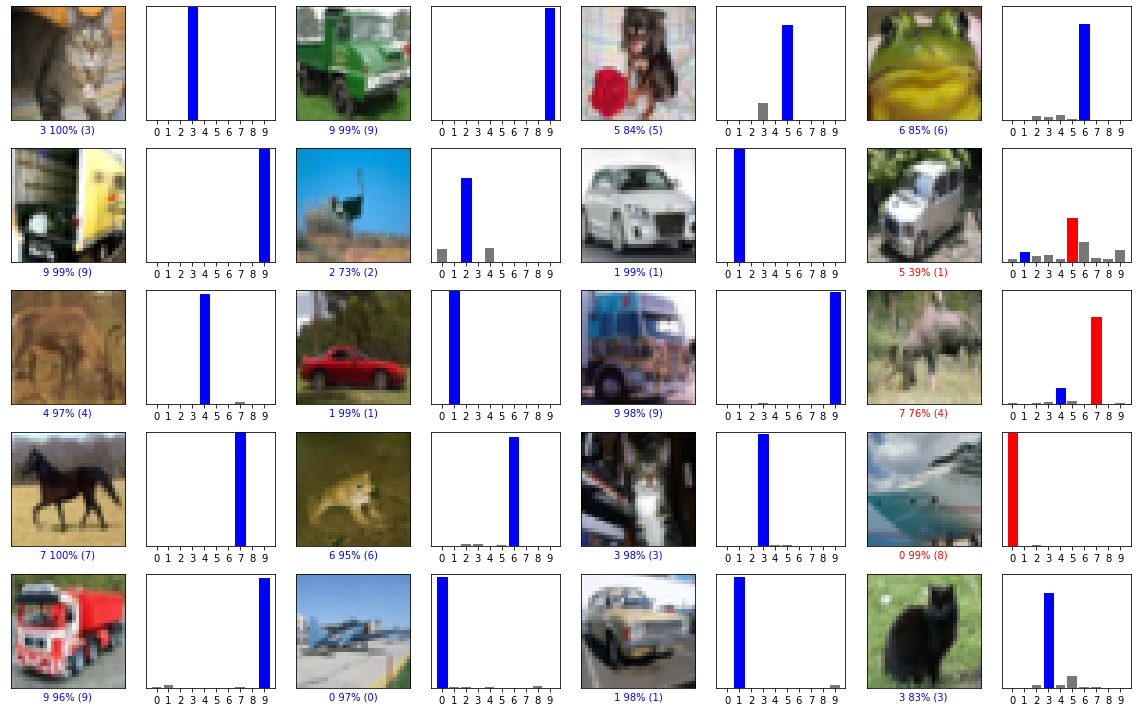

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1
    
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

In [ ]:
model10.save('cifar10_best_model.h5')